# Histogram of Coverage and X Contamination,
using David Reichs ancient data from their annotation file.
Plot and save as .pdfs into ./figures/

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.ticker import MaxNLocator

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0404.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


# Functions to Load Data
Load from Eigenstrat Annotation File of D. Reich

In [72]:
def format_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno", 
                           anc_only=True, sep="\t", dct={}, unique=False):
    """Load annotated Eigenstrat (from D. Reich's group).
    Unique: Whether to only load unique ancients"""
    df = pd.read_csv(path, sep=sep, engine="python")
    if len(dct)>0:
        df = df.rename(columns=dct)
    
    # Convert Coverage
    coverage = pd.to_numeric(df["coverage"], errors='coerce')
    df["coverage"]=coverage

    # Convert the Ages as well
    ages = df["age"]
    df["age"] = pd.to_numeric(ages, errors='coerce')  
    
    # Convert X Contamination:
    contX = df["contX"]
    df["contX"] = pd.to_numeric(contX, errors='coerce')
    
    ### Convert Longitude and Latitude
    lat = df["lat"]
    lon = df["lon"]
    df["lat"] = pd.to_numeric(lat, errors='coerce')
    df["lon"] = pd.to_numeric(lon, errors='coerce')
    
    df_anc = df[df["age"]>0]

    print(f"Found {len(df_anc)} / {len(df)} ancient Indivdiuals.")
    print(f"Without Coverage: {np.sum(np.isnan(coverage))}")
    
    if unique:
        df = df.sort_values(by="coverage", ascending=False)
        df = df.drop_duplicates(subset="iid")
        print(f"Filtered to {len(df)} unique Individuals")
    if anc_only:
        df=df[df["age"]>0]
        print(f"Filtered to {len(df)} Ancient Individuals")
    return df

# Load and partially process v42 Meta

In [102]:
rename_dct = {'Average of 95.4% date range in calBP (defined as 1950 CE)  ':"age",
              "Xcontam ANGSD MOM point estimate (only if male and ≥200)":"contX",
              'Coverage on autosomal targets':"coverage",
              "Master ID":"iid",
              'Lat.':"lat",
              "Long.":"lon"}

df_anc = format_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw.v42.4/v42.4.1240K.anno", sep="\t",
                       anc_only=True, dct=rename_dct, unique=True)

Found 3723 / 6676 ancient Indivdiuals.
Without Coverage: 2543
Filtered to 6507 unique Individuals
Filtered to 3574 Ancient Individuals


### Histogram of Ages

In [81]:
def hist_ages(df_meta, ax=0, fs=14, lim=[0,3.5e4], bin_step=250, figsize=(6,4), xy_t=[0.8,0.8],
              xlim=[], ylim=[0,230], lw=1.0, ec="k", c="blue", savepath="", c2="maroon",
              labelpad=0, text=True, show=True):
    """Do Histogram of Sample Ages"""
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["age"])
    x_cdf = x_cdf[~np.isnan(x_cdf)]
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
    
    bins = np.arange(lim[0], lim[1], bin_step) - 0.5 # Make 200 year bins
    ages = df_meta["age"]
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    ax=plt.gca()
    ax.hist(ages, color=c, ec=ec, bins=bins, lw=lw)
    #ax.axvline(0.5, color="red", lw=2)
    ax.set_ylim(ylim)
    if len(xlim)==0:
        xlim=lim
    ax.set_xlim(xlim)
    ax.set_xlabel("Avg. Age [years BP]", fontsize=fs)
    ax.set_ylabel("Count", fontsize=fs)
    if text:
        ax.text(x=xy_t[0], y=xy_t[1], ha="right", va="top",
                s=f"# Ancient Ind.: {len(df_anc)}", transform=ax.transAxes, fontsize=fs)
    
    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=0, fontsize=fs, labelpad=labelpad)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    if show:
        plt.show()
    else:   #### Abuse as Keyword to signal that this plot is used in summary Plot
        ax.set_xlabel("")
        ax.set_xticks([])

Saved to ./figures/manuscript/histograms/hist_ages.pdf


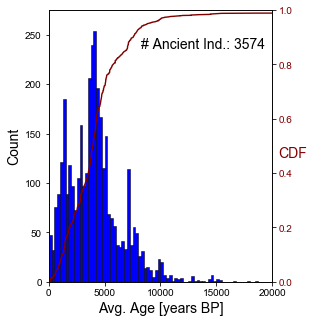

In [82]:
hist_ages(df_anc, figsize=(4,5), ec="k", c="blue", lw=0.5, ylim=[0,275], xy_t=(0.97,0.9),
          lim=[0,2e4], savepath="./figures/manuscript/histograms/hist_ages.pdf")

### Histogram of Coverage 1240k SNPs

In [89]:
def hist_coverage(df_meta, ax=0, figsize=(4,5), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,25], ylim=[0,500], savepath="", c2="maroon", fs=14):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["coverage"])
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
 
    bins = np.arange(bins[0], bins[1], bin_step)
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax=plt.gca()
    
    ax=plt.gca()
    plt.hist(df_meta["coverage"], color=c, ec=ec, bins=bins, lw=0.5)
    ax.axvline(0.5, color="red", lw=1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    plt.xlabel(f"Avg. Coverage 1240k (bin width: {bins[1]-bins[0]:.2f})", fontsize=fs)
    plt.ylabel("Count", fontsize=fs)

    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/manuscript/histograms/hist_covs.pdf


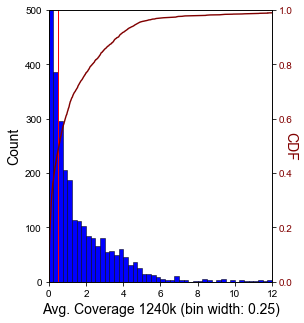

In [97]:
hist_coverage(df_anc, figsize=(4,5), bin_step=0.25, xlim=[0,12], ec="k", c="blue", ylim=[0,500],
              c2="maroon", savepath="./figures/manuscript/histograms/hist_covs.pdf")

### Histogram of X Contamination

In [91]:
def hist_xcont(df_meta, figsize=(4,5), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,1], ylim=[0,200], savepath="", c2="maroon", fs=14):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["contX"])
    x_cdf = x_cdf[~np.isnan(x_cdf)]
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)

    bins = np.arange(bins[0], bins[1], bin_step)

    plt.figure(figsize=figsize)
    
    ax=plt.gca()
    plt.hist(df_meta["contX"], color=c, ec=ec, bins=bins, lw=lw)
    
    ax.axvline(0.5, color="red", lw=1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    plt.xlabel(f"Estimated X Cont. (bin width: {bins[1]-bins[0]:.3f})", fontsize=fs)
    plt.ylabel("Count", fontsize=fs)

    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/manuscript/histograms/hist_xcont.pdf


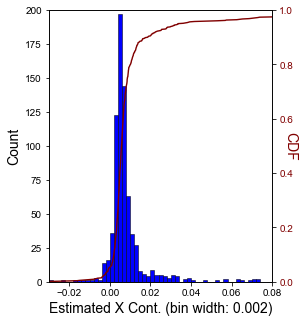

In [94]:
hist_xcont(df_anc, figsize=(4,5), bins=[-0.03,0.08], bin_step=0.002, 
           xlim=[-0.03,0.08], ylim=[0,200], ec="k", c="blue", c2="maroon", savepath="./figures/manuscript/histograms/hist_xcont.pdf")

# Do combined figure with histogram for Age & Coverage

In [9]:
##### Functions to do parts of the Plot
### Histogram Age
### Worked into above function

### Histogram 
def hist_coverage_vert(df_meta, ax=0, figsize=(8,4), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,25], ylim=[0,500], savepath="", c2="maroon", fs=14, ax2label=False, lw_05=2):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["mean_cov"])
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
 
    bins = np.arange(bins[0], bins[1], bin_step)
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax=plt.gca()
    
    ax=plt.gca()
    plt.hist(df_meta["mean_cov"], orientation="horizontal",
             color=c, ec=ec, bins=bins, lw=0.5)
    ax.axhline(0.5, color="red", lw=lw_05)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Count", fontsize=fs)
    ax.set_yticks([])
 
    ax2 = ax.twiny()
    ax2.plot(y_cdf, x_cdf, c=c2, lw=1.4)
    if ax2label:
        ax2.set_xlabel("CDF", color=c2, rotation=0, fontsize=fs)
        plt.setp(ax2.get_xticklabels(), color=c2)
    else:
        ax2.set_xticks([0.5, 1.0])
        plt.setp(ax2.get_xticklabels(), color=c2)
        #ax2.set_xticklabels([0.5, 1.0])
    ax2.set_xlim([0,1])
    

### Combined Figure
def scatter_age_cov(df_meta, ax, s=20, ec="k", c="blue", xlim=[0, 25000], ylim=[0,50],
                    alpha=1.0, xlabel="Age [years BP]", ylabel="Average Coverage (1240k)", fs=10):
    """Plots Scatter Plot Coverage vrs Age.
    df_meta: Gets input data from there
    ax: Axis to plot on"""
    ax.scatter(df_meta["age"], df_meta["mean_cov"], ec="k", c=c, s=s, alpha=alpha)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)

    ax.text(x=0.62, y=0.93, 
        s=f"Total Number ancients: {len(df_meta)}", transform=ax.transAxes, fontsize=fs)

In [58]:
### Call All Subfigures
def plot_anc_panel(df_meta, figsize=(9,4), fs=10, width_ratios = [6, 1],
                   height_ratios = [1, 3], wspace = 0.02, hspace = 0.04,
                   xlim_a = [-150, 20000], ylim_c = [-0.4, 10], s=18, alpha=1.0,
                   labelpad_age = 20, c="DeepPink", c2="coral", savepath=""):
    """Plot Panel with scatter plot of coverage vrs age, and the summary statistics"""
    fig=plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=width_ratios, height_ratios=height_ratios, figure=fig)
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    ax_scatter = plt.subplot(gs[1,0])
    scatter_age_cov(df_meta, ax_scatter, xlim=xlim_a, ylim=ylim_c, 
                    c=c, fs=fs, s=s, alpha=alpha)

    ax_age_hist = plt.subplot(gs[0,0])
    hist_ages(df_meta, ax_age_hist, xlim=xlim_a, labelpad=labelpad_age, text=False, 
              c=c, c2=c2, show=False, fs=fs)

    ax_cov_hist = plt.subplot(gs[1,1])
    hist_coverage_vert(df_meta, ax_cov_hist, xlim=[0,500], ylim=ylim_c, bin_step=0.25, 
                       c=c, c2=c2, fs=fs)

    ### Some final touches
    ax_scatter.xaxis.set_major_locator(MaxNLocator(prune='upper'))
    ax_scatter.yaxis.set_major_locator(MaxNLocator(prune='upper'))
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
        
    plt.show()

Saved to ./figures/manuscript/histograms/panel_hist.pdf


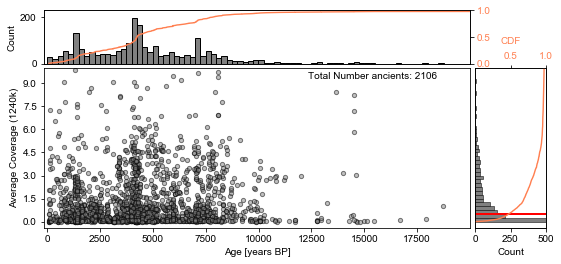

In [69]:
plot_anc_panel(df_meta, savepath="./figures/manuscript/histograms/panel_hist.pdf", 
               c="gray", alpha=0.5)

# Statistics of clean unique samples

In [123]:
df = pd.read_csv("./Data/ReichLabEigenstrat/Raw/meta.csv")

In [124]:
df_clean = df[df["include_alt"]>0]
print(f"Include okay: {len(df_clean)}/{len(df)}")

Include okay: 1936/2106


In [115]:
coverages = [0.5,5]
for c in coverages:
    h=np.sum(df_clean["mean_cov"]>c)
    print(f"Min. Coverage>{c}: {h}/{len(df_clean)}")

Min. Coverage>0.5: 1052/1936
Min. Coverage>5: 134/1936


### Coverage for all unique Ancients

In [117]:
coverages = [0.5,5]
for c in coverages:
    h=np.sum(df_anc["coverage"]>c)
    print(f"Min. Coverage>{c}: {h}/{len(df_anc)}")

Min. Coverage>0.5: 1833/3574
Min. Coverage>5: 152/3574


In [122]:
np.sum(df_anc["SNPs hit on autosomal targets"]>4e5)

1856

# Area 51
Test Code here

In [21]:
np.quantile(df_meta["mean_cov"].values, q=0.5)

nan

In [39]:
df_meta.sort_values(by="mean_cov").iloc[1900,:]

iid                       I2933
lat                       58.74
lon                      -2.916
age                        4898
study          OlaldeNature2018
clst                 Scotland_N
mean_cov                  4.261
n_cov_snp                736264
include_alt                   1
sex                           M
contX                  0.000895
Name: 1276, dtype: object

In [28]:
len(df_meta)

2106